In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Sample Ka data from (http://www.atmo.ttu.edu/bruning/5331/Ka2140614021408.RAWPXA9.nc). These data were converted directly from the raw format collected by the radar (Sigmet) to the [NetCDF CF/Radial standard](http://ncar.github.io/CfRadial/). No further processing has been applied.

In [16]:
d = xr.open_dataset('Ka2140614021408.RAWPXA9.nc')

print(d)

# Print the first ten elevation angles.
print(d.variables['elevation'][0:10])

# Shortcut to variable access
print(d.elevation[0:10])

<xarray.Dataset>
Dimensions:                    (range: 1666, sweep: 5, time: 2938)
Coordinates:
  * time                       (time) datetime64[ns] 2014-06-14T02:14:19 ... ...
  * range                      (range) float32 0.0 15.0 30.0 ... 24960.0 24975.0
    azimuth                    (time) float32 ...
    elevation                  (time) float32 ...
Dimensions without coordinates: sweep
Data variables:
    total_power                (time, range) float32 ...
    reflectivity               (time, range) float32 ...
    velocity                   (time, range) float32 ...
    spectrum_width             (time, range) float32 ...
    normalized_coherent_power  (time, range) float32 ...
    sweep_number               (sweep) int32 ...
    fixed_angle                (sweep) float32 ...
    sweep_start_ray_index      (sweep) int32 ...
    sweep_end_ray_index        (sweep) int32 ...
    sweep_mode                 (sweep) |S32 ...
    unambiguous_range          (time) float32 ...
    pr

<xarray.DataArray 'sweep_mode' (sweep: 5)>
array([b'rhi', b'rhi', b'rhi', b'rhi', b'rhi'], dtype='|S32')
Dimensions without coordinates: sweep
Attributes:
    long_name:      Sweep mode
    units:          unitless
    standard_name:  sweep_mode
    comment:        Options are: "sector", "coplane", "rhi", "vertical_pointi...
<xarray.DataArray 'sweep_start_ray_index' (sweep: 5)>
array([   0,  590, 1176, 1766, 2352])
Dimensions without coordinates: sweep
Attributes:
    long_name:  Index of first ray in sweep, 0-based
    units:      count
<xarray.DataArray 'sweep_end_ray_index' (sweep: 5)>
array([ 589, 1175, 1765, 2351, 2937])
Dimensions without coordinates: sweep
Attributes:
    long_name:  Index of last ray in sweep, 0-based
    units:      count


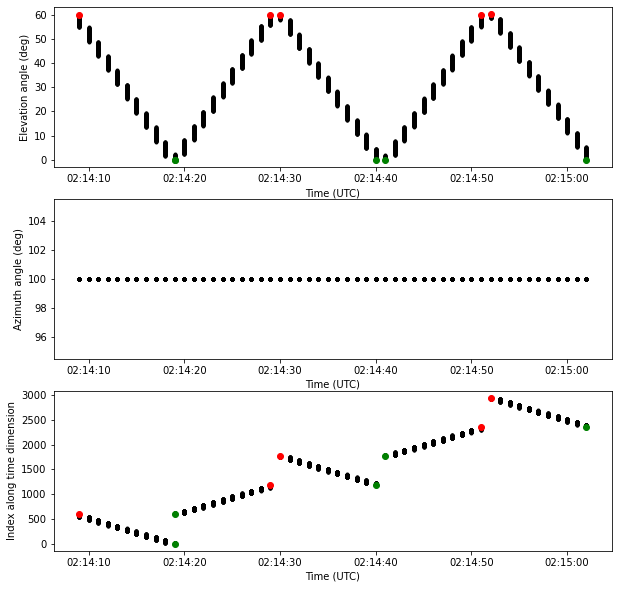

In [17]:
print(d.sweep_mode)
print(d.sweep_start_ray_index)
print(d.sweep_end_ray_index)

az = d.azimuth[:]
el = d.elevation[:]
t = d.time[:]
fig, axs = plt.subplots(3,1, squeeze=False, figsize=(10,10))

axs[0,0].plot(t,el, '.k')
axs[0,0].set_ylabel('Elevation angle (deg)')
axs[0,0].set_xlabel('Time (UTC)')
axs[1,0].plot(t,az, '.k')
axs[1,0].set_ylabel('Azimuth angle (deg)')
axs[1,0].set_xlabel('Time (UTC)')
axs[2,0].plot(t, np.arange(t.shape[0]), '.k')
axs[2,0].set_ylabel('Index along time dimension')
axs[2,0].set_xlabel('Time (UTC)')
for sw_start, sw_end in zip(d.sweep_start_ray_index, d.sweep_end_ray_index):
    axs[0,0].plot(t[sw_start], el[sw_start], marker='o', color='g')
    axs[0,0].plot(t[sw_end], el[sw_end], marker='o',color='r')
    axs[2,0].plot(t[sw_start], sw_start, marker='o', color='g')
    axs[2,0].plot(t[sw_end], sw_end, marker='o',color='r')

In [18]:
scan_idx = 1

(587, 1667) [[100.00029755 100.00029755 100.00029755 ... 100.00029755 100.00029755
  100.00029755]
 [100.00029755 100.00029755 100.00029755 ... 100.00029755 100.00029755
  100.00029755]
 [100.00029755 100.00029755 100.00029755 ... 100.00029755 100.00029755
  100.00029755]
 ...
 [100.00029755 100.00029755 100.00029755 ... 100.00029755 100.00029755
  100.00029755]
 [100.00029755 100.00029755 100.00029755 ... 100.00029755 100.00029755
  100.00029755]
 [100.00029755 100.00029755 100.00029755 ... 100.00029755 100.00029755
  100.00029755]] [[-2.06085313e-02 -2.06085313e-02 -2.06085313e-02 ... -2.06085313e-02
  -2.06085313e-02 -2.06085313e-02]
 [ 8.10211077e-02  8.10211077e-02  8.10211077e-02 ...  8.10211077e-02
   8.10211077e-02  8.10211077e-02]
 [ 1.79901093e-01  1.79901093e-01  1.79901093e-01 ...  1.79901093e-01
   1.79901093e-01  1.79901093e-01]
 ...
 [ 5.98535080e+01  5.98535080e+01  5.98535080e+01 ...  5.98535080e+01
   5.98535080e+01  5.98535080e+01]
 [ 5.99523849e+01  5.99523849e+01  

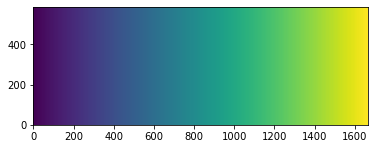

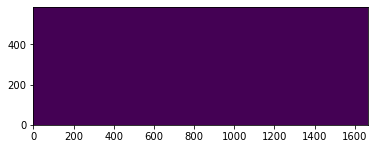

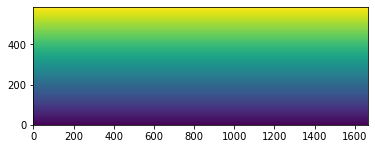

In [19]:
def centers_to_edges_1d(x):
    x_edge = x.shape[0] +1
    xe = np.empty (x_edge)
    xe [1:-1] = (x[1:] +x[:-1])/2.0
    xe [0] = x[0] - ((x[1] - x[0])/2)
    xe [-1] = x[-1] + ((x[-1] - x[-2])/2.0)
    return xe

def coords_2d(data, scan_idx):
    """
    Takes an xarray data set d containing radar data and create a mesh using
    the range and elevation coordinates of the nth scan/sweep
    
    Returns the values for:
    r: range along beam (1D array)
    az: azimuthal angle (1D array)
    el: elevation angle (1D array)
    R: range mesh along beam (2D array)
    EL: elevation angle mesh (2D array)
    
    start: starting index of the nth scan
    end: emdimg index of the nth scan
    
    """
    # Find the start and end indices of the nth scan. Here scan index = 1
    
    start = data.sweep_start_ray_index[scan_idx].values
    end = data.sweep_end_ray_index[scan_idx].values+1
    
    # Create the edges
    
    r = centers_to_edges_1d(data.range.values)
    az = centers_to_edges_1d(data.azimuth[start:end].values)
    el = centers_to_edges_1d(d.elevation[start:end].values)
    
    #2-d grid
    
    R, AZ = np.meshgrid(r, az)
    R, EL = np.meshgrid(r, el)
    
    return R, AZ, EL

r, az, el = coords_2d(d, scan_idx)

print(r.shape, az, el)

plt.imshow(r, origin='lower')
plt.show()
plt.imshow(az, origin='lower')
plt.show()
plt.imshow(el, origin='lower')
plt.show()

4-panel plot of reflectivity, velocity, spectrum width, and normalized coherent power. 

<IPython.core.display.Javascript object>


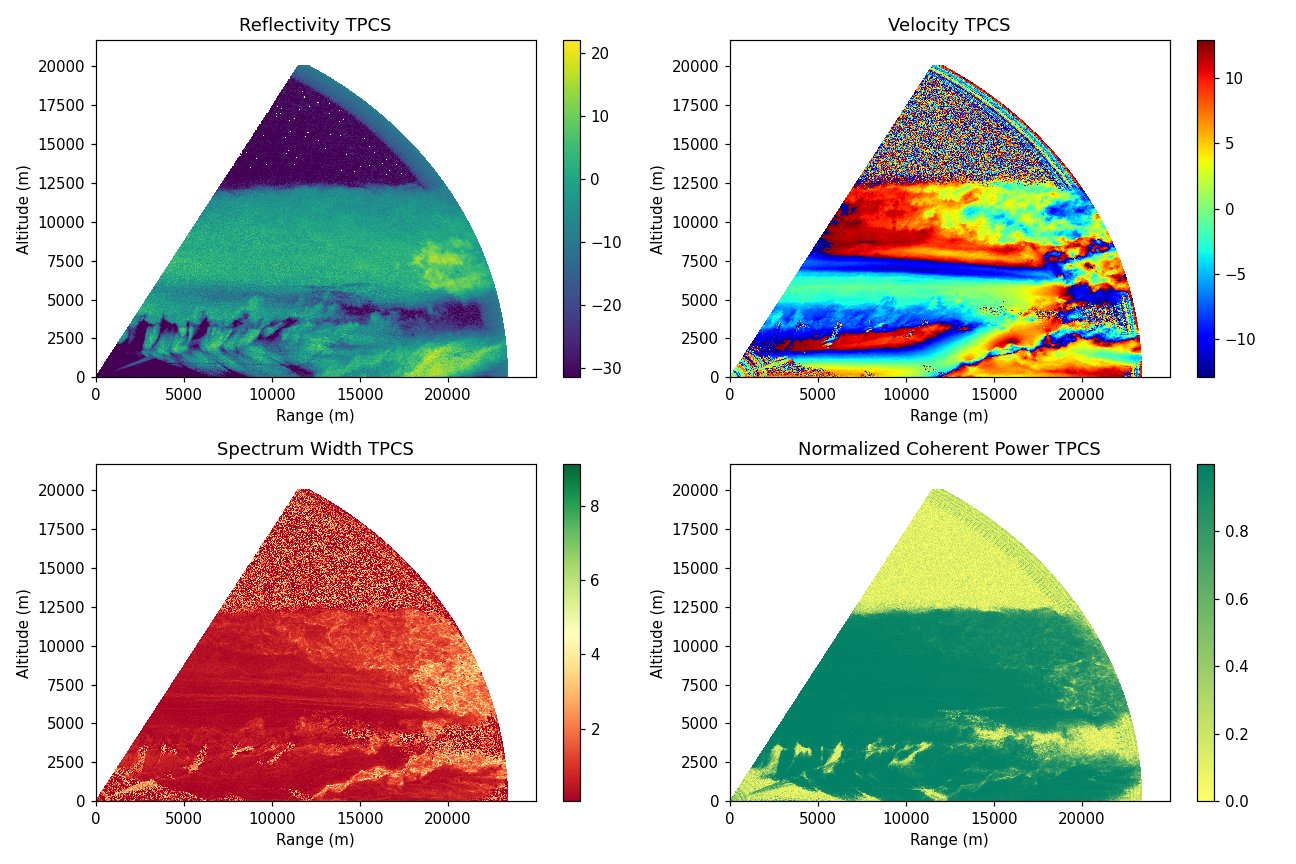

In [20]:
from coordinateSystems import RadarCoordinateSystem
from coordinateSystems import TangentPlaneCartesianSystem

start = d.sweep_start_ray_index[scan_idx].values
end = d.sweep_end_ray_index[scan_idx].values+1

rcs = RadarCoordinateSystem(d.latitude, d.longitude, d.altitude)
tan = TangentPlaneCartesianSystem(d.latitude, d.longitude, d.altitude)

"""
   X_T, Y_T, Z_T = tan.fromECEF(X, Y, Z)

   GR = np.sqrt(X_T**2+Y_T**2)
   H = Z_T
"""

GR, H = rcs.getGroundRangeHeight(r, el)

GR.shape = r.shape
H.shape = el.shape

"""
Convert slant range (along the beam) and elevation angle into
ground range (great circle distance) and height above the earth's surface
Follows Doviak and Zrnic 1993, eq. 2.28.

"""

Reflectivity = d.reflectivity.isel(time = slice(start,end))
Velocity = d.velocity.isel(time = slice(start,end))
SpectrumWidth = d.spectrum_width.isel(time = slice(start,end))
NormalizedCoherentPower = d.normalized_coherent_power.isel(time = slice(start,end))

%matplotlib notebook
n_rows, n_cols = 2, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12,8))

im1 = axes[0,0].pcolormesh(GR, H, Reflectivity)
plt.colorbar(im1, ax = axes[0,0])
axes[0,0].set_title("Reflectivity TPCS")
axes[0,0].set_xlabel("Range (m)")
axes[0,0].set_ylabel("Altitude (m)")

im2 = axes[0,1].pcolormesh(GR, H, Velocity, cmap=plt.cm.jet)
plt.colorbar(im2, ax = axes[0,1])
axes[0,1].set_title("Velocity TPCS")
axes[0,1].set_xlabel("Range (m)")
axes[0,1].set_ylabel("Altitude (m)")

im3 = axes[1,0].pcolormesh(GR, H, SpectrumWidth, cmap=plt.cm.RdYlGn)
plt.colorbar(im3, ax = axes[1,0])
axes[1,0].set_title("Spectrum Width TPCS")
axes[1,0].set_xlabel("Range (m)")
axes[1,0].set_ylabel("Altitude (m)")

im4 = axes[1,1].pcolormesh(GR, H, NormalizedCoherentPower, cmap=plt.cm.summer_r)
plt.colorbar(im4, ax = axes[1,1])
axes[1,1].set_title("Normalized Coherent Power TPCS")
axes[1,1].set_xlabel("Range (m)")
axes[1,1].set_ylabel("Altitude (m)")
plt.tight_layout()


Aziuthal equidistant map projection

In [21]:

print(d.latitude)
print(d.longitude)
from coordinateSystems import MapProjection

aeqd = MapProjection(projection='aeqd', lon_0=float(d.longitude), lat_0=float(d.latitude))

X, Y, Z = rcs.toECEF(r, az, el)
projX, projY, projZ = aeqd.fromECEF(X, Y, Z)

projX.shape = r.shape
projY.shape = az.shape
projZ.shape = el.shape

%matplotlib notebook
n_rows, n_cols = 2, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12,8))

im1 = axes[0,0].pcolormesh(projX, projZ, Reflectivity)
plt.colorbar(im1, ax = axes[0,0])
axes[0,0].set_title("Reflectivity AEQD")
axes[0,0].set_xlabel("Range (m)")
axes[0,0].set_ylabel("Altitude (m)")

im2 = axes[0,1].pcolormesh(projX, projZ, Velocity, cmap=plt.cm.jet)
plt.colorbar(im2, ax = axes[0,1])
axes[0,1].set_title("Velocity AEQD")
axes[0,1].set_xlabel("Range (m)")
axes[0,1].set_ylabel("Altitude (m)")

im3 = axes[1,0].pcolormesh(projX, projZ, SpectrumWidth, cmap=plt.cm.RdYlGn)
plt.colorbar(im3, ax = axes[1,0])
axes[1,0].set_title("Spectrum Width AEQD")
axes[1,0].set_xlabel("Range (m)")
axes[1,0].set_ylabel("Altitude (m)")

im4 = axes[1,1].pcolormesh(projX, projZ, NormalizedCoherentPower, cmap=plt.cm.summer_r)
plt.colorbar(im4, ax = axes[1,1])
axes[1,1].set_title("Normalized Coherent Power AEQD")
axes[1,1].set_xlabel("Range (m)")
axes[1,1].set_ylabel("Altitude (m)")
plt.tight_layout()



<xarray.DataArray 'latitude' ()>
array(34.72259)
Attributes:
    long_name:      Latitude
    units:          degrees_north
    standard_name:  Latitude
<xarray.DataArray 'longitude' ()>
array(-76.74685)
Attributes:
    long_name:      Longitude
    units:          degrees_east
    standard_name:  Longitude


<IPython.core.display.Javascript object>